# Usefull Imports

In [5]:
# import statements for evaluation metrics
import numpy as np
import random
import cv2
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, accuracy_score, f1_score, mean_squared_error, r2_score, precision_score

# import statements for data preprocessing and augmentation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# import statements for deep learning models

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from keras import applications
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn
import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import statements for training callbacks and utilities
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# import statements for data handling and processing
from sklearn.model_selection import train_test_split
from pickle import dump, load
import csv
import os
from PIL import Image
from tensorflow.python.framework import ops
from random import shuffle

import os
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from pickle import load



Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Data preprocessing function

In [4]:
def create_train_data_ZZ(TRAIN_DIR, Label_Dir, IMG_SIZE):
    # Create empty lists to store training data and labels
    training_data = []
    label_data = []

    # Initialize counters to keep track of the number of labels with value 0 and 1
    c0 = 0
    c1 = 0

    # Read labels only
    for folder in os.listdir(Label_Dir):
        c0 = 0  # reset counter for each subfolder
        for inner_folder in os.listdir((Label_Dir+'/'+folder)):
            # Get the path of each file in the subfolder
            path = os.path.join(Label_Dir, folder+'/'+inner_folder)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                # Check if the file is a text file
                if file_path.endswith('.txt'):
                    try:
                        with open(file_path, 'r') as f:
                            content = f.read()
                            # Do something with the content of the file
                        with open(file_path, 'r') as f:
                            lines = f.readlines()
                            # Check the value of the third character of the first line of the text file
                            if (lines[0][3] == '0' and c0 < 340):
                                # If the value is 0 and there are fewer than 340 labels with value 0,
                                # append the label with a value of 0 to the label_data list
                                label_data.append('0')
                                c0 += 1
                            elif (lines[0][3] != '0'):
                                # If the value is not 0, append the label with a value of 1 to the label_data list
                                label_data.append('1')
                                c1 += 1
                        f.close()
                    except Exception as e:
                        pass

    # Append a dummy label value of -1 to mark the end of the label_data list
    label_data.append('-1')

    # Read images and their corresponding labels
    c = 0  # counter to keep track of the current label index
    c0 = 0  # counter to keep track of the number of labels with value 0
    c1 = 0  # counter to keep track of the number of labels with value 1
    for folder in os.listdir(TRAIN_DIR):
        c0 = 0  # reset counter for each subfolder
        for inner_folder in os.listdir((TRAIN_DIR+'/'+folder)):
            # Get the path of each file in the subfolder
            path = os.path.join(TRAIN_DIR, folder+'/'+inner_folder)
            for img in tqdm(os.listdir(path)):
                img = os.path.join(path+'/'+img)
                try:
                    # Read and preprocess the image data
                    img_data = cv2.imread(img, cv2.IMREAD_COLOR)
                    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
                    img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
                    continue

                # Check the current label value from the label_data list
                if (label_data[c] == '-1'):
                    # If the dummy label value is reached, exit the loop
                    break
                if (label_data[c] == '0' and c0 < 340):
                    # If the label value is 0 and there are fewer than 340 labels with value 0,
                    # append the image data with the corresponding label value of 0
                                        training_data.append([np.array(img_data), label_data[c]])
                    c0 += 1
                    c += 1
                if (label_data[c] != '0'):
                    # If the label value is not 0, append the image data with the corresponding label value of 1
                    training_data.append([np.array(img_data), label_data[c]])
                    c1 += 1
                    c += 1

    # Shuffle the training data
    shuffle(training_data)

    # Save the training data as a pickle file
    dump(training_data, open('training_data.pkl', 'wb'))

    # Return the training data
    return training_data


# Usefull functions

In [10]:
def balance_data(training_data, target_c0, target_c1):
    # Create empty lists to store samples from class 0 and class 1
    class_0 = []
    class_1 = []

    # Separate the samples based on their class
    for sample in training_data:
        if sample[1] == '0':
            class_0.append(sample)
        else:
            class_1.append(sample)

    # Balance the data by keeping only the target number of samples for each class
    class_0 = class_0[:target_c0]
    class_1 = class_1[:target_c1]

    # Combine and shuffle the balanced data
    balanced_data = class_0 + class_1
    shuffle(balanced_data)

    return balanced_data

# Load the training data
training_data = load(open('training_data.pkl', 'rb'))

# Define the target number of samples for each class
target_c0 = 15  # Set it to the maximum number of samples contained in the dataset
target_c1 = 1000

# Balance the data
balanced_training_data = balance_data(training_data, target_c0, target_c1)

# Now you can use the balanced_training_data variable for further processing


In [11]:
def count_classes(data):
    # Initialize counters for class 0 and class 1
    count_0 = 0
    count_1 = 0

    # Count the number of samples for each class
    for sample in data:
        if sample[1] == '0':
            count_0 += 1
        else:
            count_1 += 1

    # Return the counts
    return count_0, count_1

# Count the samples for each class in the balanced_training_data
count_0, count_1 = count_classes(balanced_training_data)

# Print the counts and the total number of samples
print(f"Number of class '0' samples: {count_0}")
print(f"Number of class '1' samples: {count_1}")
print(f"Total number of samples: {len(balanced_training_data)}")


Number of class '0' samples: 15
Number of class '1' samples: 1000
Total number of samples: 1015


# Train primary model function

In [27]:
def Train_main_model(ImgSize, loss_function):
    # Load the training data from a pickle file
    if os.path.exists('training_data.pkl'):
        training_data = load(open('training_data.pkl', 'rb'))

    # Shuffle and balance the training data
    random.shuffle(training_data)
    target_c0 = 15
    target_c1 = 2000
    balanced_training_data = balance_data(training_data, target_c0, target_c1)
    training_data = balanced_training_data

    # Extract the image data and labels from the balanced training data
    X_train = np.array([i[0] for i in training_data]).reshape(-1, ImgSize, ImgSize, 3)
    y_train = [i[1] for i in training_data]

    # Convert the label values to float and separate the data by class
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_train0 = X_train[y_train == 0]
    y_train0 = y_train[y_train == 0]
    X_train1 = X_train[y_train == 1]
    y_train1 = y_train[y_train == 1]

    # Create an image data generator for augmenting the minority class data
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)
    train_generator = datagen.flow(X_train0, y_train0, batch_size=1)

    # Augment the minority class data to achieve a desired number of samples
    num_augmented_samples = 2000
    X_train0_augmented = np.zeros((num_augmented_samples, ImgSize, ImgSize, 3))
    y_train0_augmented = np.zeros(num_augmented_samples)

    for i in range(num_augmented_samples):
        X_train0_augmented[i], y_train0_augmented[i] = train_generator.next()

    # Combine the augmented data with the majority class data
    X_train_augmented = np.concatenate((X_train0_augmented, X_train1), axis=0)
    y_train_augmented = np.concatenate((y_train0_augmented, y_train1), axis=0)

    # Shuffle the augmented data
    indices = np.arange(X_train_augmented.shape[0])
    np.random.shuffle(indices)
    X_train_augmented = X_train_augmented[indices]
    y_train_augmented = y_train_augmented[indices]

    print(X_train_augmented.shape)
    print(y_train_augmented.shape)

    # Define the CNN model architecture
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(ImgSize, ImgSize, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary crossentropy loss and Adam optimizer
    model.summary()
    model.compile(optimizer='Adam', loss=loss_function, metrics=['accuracy'])

    # Define a learning rate scheduler and early stopping callback
    def step_decay(epoch):
        initial_lr = 0.001
        drop = 0.5
        epochs_drop = 5
        lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        return lr
    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
    # Define a model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_main_model_ZZ.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Split the data into training and validation sets
X_trainz, X_testz, y_trainz, y_testz = train_test_split(X_train_augmented, y_train_augmented, test_size=0.20, random_state=42)

# Convert the label values to float for training and validation sets
y_trainz = np.array(y_trainz)
y_testz = np.array(y_testz)
y_trainz = y_trainz.astype(float)
y_testz = y_testz.astype(float)

# Train the model using the augmented data
history = model.fit(X_trainz, y_trainz, epochs=5, batch_size=16, validation_data=(X_testz, y_testz), callbacks=[lr_scheduler, early_stop, checkpoint], verbose=1)

return X_testz, y_testz, history



# Train function for the other model that we compare with

In [6]:
# Define a function called 'Train' that takes in an input parameter 'ImgSize'
def Train_other_model(ImgSize):
    
    # Check if the training data pickle file exists and load it if it does
    if (os.path.exists('training_data.pkl')):
        training_data = load(open('training_data.pkl', 'rb'))
    
    # Randomly shuffle the training data and select 3500 images for training
    random.shuffle(training_data)
    # Balance the data
    target_c0 = 15
    target_c1 = 2000

    balanced_training_data = balance_data(training_data, target_c0, target_c1)


    training_data = balanced_training_data

    #ImgSize=200
    X_train = np.array([i[0] for i in training_data]).reshape(-1, ImgSize, ImgSize, 3)
    y_train = [i[1] for i in training_data]



    y_train=np.array(y_train)
    y_train = y_train.astype(float)

    # Separate the training data into classes
    X_train0 = X_train[y_train == 0]
    y_train0 = y_train[y_train == 0]

    X_train1 = X_train[y_train == 1]
    y_train1 = y_train[y_train == 1]

    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)


    train_generator = datagen.flow(X_train0, y_train0, batch_size=1)


    # Generate augmented data for class 0
    num_augmented_samples = 2000
    X_train0_augmented = np.zeros((num_augmented_samples, ImgSize, ImgSize, 3))
    y_train0_augmented = np.zeros(num_augmented_samples)

    for i in range(num_augmented_samples):
        X_train0_augmented[i], y_train0_augmented[i] = train_generator.next()

    # Concatenate the augmented data for class 0 with the data for class 1
    X_train_augmented = np.concatenate((X_train0_augmented, X_train1), axis=0)
    y_train_augmented = np.concatenate((y_train0_augmented, y_train1), axis=0)

    # Shuffle the augmented dataset to mix class 0 and class 1 samples
    indices = np.arange(X_train_augmented.shape[0])
    np.random.shuffle(indices)
    X_train_augmented = X_train_augmented[indices]
    y_train_augmented = y_train_augmented[indices]

    print(X_train_augmented.shape)
    print(y_train_augmented.shape)


    # Define model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(ImgSize, ImgSize, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
    model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Define a function called 'step_decay' that implements a learning rate schedule with exponential decay
    def step_decay(epoch):
        initial_lr = 0.001
        drop = 0.5
        epochs_drop = 5
        lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        return lr

    # Define a learning rate scheduler that uses the 'step_decay' function
    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

    # Define early stopping to prevent overfitting and save the best weights
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    # Define a checkpoint to save the weights of the best performing model
    checkpoint = ModelCheckpoint('best_other_model_ZZ.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    X_trainz, X_testz, y_trainz, y_testz = train_test_split(X_train_augmented, y_train_augmented, test_size=0.20, random_state=42)

    y_trainz=np.array(y_trainz)
    y_testz=np.array(y_testz)

    y_trainz = y_trainz.astype(float)
    y_testz = y_testz.astype(float)


    # Train the model using the augmented training data and the defined callbacks
    history = model.fit(X_trainz, y_trainz, epochs=5, batch_size=32, validation_data=(X_testz, y_testz), callbacks=[lr_scheduler, early_stop, checkpoint], verbose=1)
    
    return X_testz, y_testz,history
    

# Data preprocessing and data info

In [5]:
# Define the arguments needed to create the training data for the machine learning model
# The first argument is the directory path to the images
# The second argument is the directory path to the frame labels
# The third argument is the number of frames to be included in the training data
images_directory = 'E:/pain_dataset/Images/Images/'
labels_directory = 'E:/pain_dataset/Frame_labels/Frame_Labels/FACS/'
num_frames = 200

# Call the create_train_data_ZZ() function to create the training data
# The function creates and returns the training data as a data structure suitable for machine learning
training_data = create_train_data_ZZ(images_directory, labels_directory, num_frames)

15 14599
14615


  0%|          | 0/420 [00:00<?, ?it/s]


15 14599


In [7]:
# Print the number of samples in the training_data list
# The len() function returns the number of items in a list
print("Number of samples in the training_data list:", len(training_data))

# Initialize variables for counting the number of instances in each class
# The class labels are assumed to be binary, with '0' representing one class and '1' representing the other
class_0_count = 0
class_1_count = 0

# Loop through each data item in the training_data list
# Each data item is a tuple with two elements: the image data and the label
for data in training_data:
    # Extract the label from the data (ignoring the image data)
    _, label = data 
    
    # Check the value of the label and increment the appropriate count variable
    # If the label is '0', increment the count of class 0 instances
    if label == '0':
        class_0_count += 1
    # If the label is '1', increment the count of class 1 instances
    elif label == '1':
        class_1_count += 1

# Print the number of instances in each class
print("Number of class 0 instances:", class_0_count)
print("Number of class 1 instances:", class_1_count)


14614
Number of class 0 instances: 15
Number of class 1 instances: 14599


## Showing some samples from the  dataset

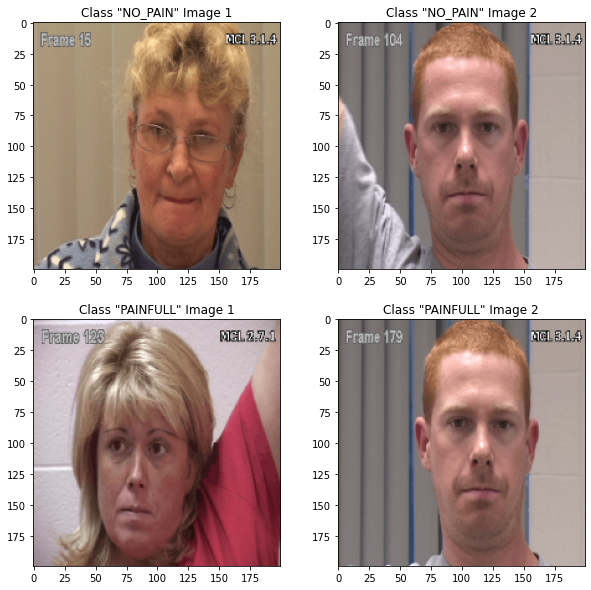

In [8]:
# Set the size of the images to be plotted
IMG_SIZE = 200

# Create empty lists to store images of class 0 and 1
class_0 = []
class_1 = []

# Loop through training data and append images to class_0 and class_1 lists
# Stop looping once two images from each class have been added to the lists
for data in training_data:
    img, label = data
    
    # If the label is '0' and less than two images have been added to class_0, add the image to class_0
    if label == '0' and len(class_0) < 2:
        class_0.append(img)
    # If the label is '1' and less than two images have been added to class_1, add the image to class_1
    elif label == '1' and len(class_1) < 2:
        class_1.append(img)
    
    # If two images have been added to both class_0 and class_1, stop looping through the training data
    if len(class_0) == 2 and len(class_1) == 2:
        break

# Plot the images
# Create a figure with a 2x2 grid of subplots
# The figsize parameter determines the size of the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first image in class_0 in the top-left subplot
axs[0, 0].imshow(class_0[0])
axs[0, 0].set_title('Class "NO_PAIN" Image 1')

# Plot the second image in class_0 in the top-right subplot
axs[0, 1].imshow(class_0[1])
axs[0, 1].set_title('Class "NO_PAIN" Image 2')

# Plot the first image in class_1 in the bottom-left subplot
axs[1, 0].imshow(class_1[0])
axs[1, 0].set_title('Class "PAINFUL" Image 1')

# Plot the second image in class_1 in the bottom-right subplot
axs[1, 1].imshow(class_1[1])
axs[1, 1].set_title('Class "PAINFUL" Image 2')

# Show the plot
plt.show()


# 1. Prediction accuracy for CNN and another network you compared with.


## Train model1 

In [9]:
# Set the size of the input images to be 200 x 200 pixels
input_size = 200

# Call the Train_main_model() function with input_size=200 and loss_function='binary_crossentropy'
# The function returns three variables: X_test1, y_test1, and history
# X_test1 contains the input data for the test set
# y_test1 contains the labels for the test set
# history contains information about the training of the model, such as the loss and accuracy over time
X_test1, y_test1, history1 = Train_main_model(input_size, loss_function='binary_crossentropy')


(4000, 200, 200, 3)
(4000,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 64)                20072512  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                            

d:\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.46982, saving model to best_main_model_ZZ.h5
3200/3200 [==============================] - 466s 146ms/sample - loss: 34.8617 - acc: 0.6094 - val_loss: 0.4698 - val_acc: 0.5200 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
3200/3200 [==============================] - ETA: 0s - loss: 0.6000 - acc: 0.6328
Epoch 2: val_loss improved from 0.46982 to 0.32193, saving model to best_main_model_ZZ.h5
3200/3200 [==============================] - 285s 89ms/sample - loss: 0.6000 - acc: 0.6328 - val_loss: 0.3219 - val_acc: 0.9875 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/5
3200/3200 [==============================] - ETA: 0s - loss: 0.5462 - acc: 0.6997
Epoch 3: val_loss improved from 0.32193 to 0.29992, saving model to best_main_model_ZZ.h5
3200/3200 [==============================] - 225s 70ms/sample - loss: 0.5462 - acc: 0.6997 - val_loss: 0.2999 - val_acc: 0.9875 - lr: 0.0

## Train model2

In [10]:
# Set the size of the input images to be 200 x 200 pixels
input_size = 200

# Call the Train_other_model() function with an input size of 200
# The function returns three variables: X_test2, y_test2, and history2
# X_test2 contains the input data for the test set
# y_test2 contains the labels for the test set
# history2 contains information about the training of the model, such as the loss and accuracy over time
X_test2, y_test2, history2 = Train_other_model(input_size)


(4000, 200, 200, 3)
(4000,)
Train on 3200 samples, validate on 800 samples

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
3200/3200 [==============================] - ETA: 0s - loss: 19.2994 - acc: 0.8703
Epoch 1: val_loss improved from inf to 0.27751, saving model to best_other_model_ZZ.h5
3200/3200 [==============================] - 624s 195ms/sample - loss: 19.2994 - acc: 0.8703 - val_loss: 0.2775 - val_acc: 0.9463 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
3200/3200 [==============================] - ETA: 0s - loss: 0.8924 - acc: 0.9706
Epoch 2: val_loss improved from 0.27751 to 0.00000, saving model to best_other_model_ZZ.h5
3200/3200 [==============================] - 423s 132ms/sample - loss: 0.8924 - acc: 0.9706 - val_loss: 5.4171e-34 - val_acc: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/5
3200/3200 [==============================] - ETA: 0s - loss: 0.0150 - a

### model1

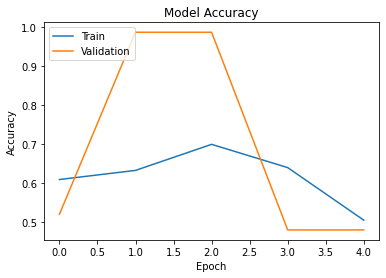

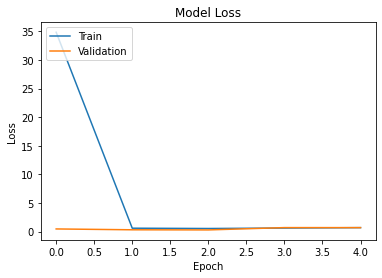

In [11]:
# Get the training history for model 1
# The 'history' variable contains information about the training of the model, such as the loss and accuracy over time
history = history1.history

# Plot the accuracy of the model
# The 'acc' key in the 'history' dictionary contains the training accuracy
# The 'val_acc' key in the 'history' dictionary contains the validation accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss of the model
# The 'loss' key in the 'history' dictionary contains the training loss
# The 'val_loss' key in the 'history' dictionary contains the validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### model2

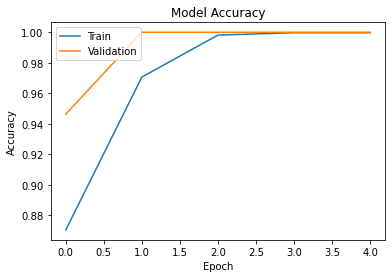

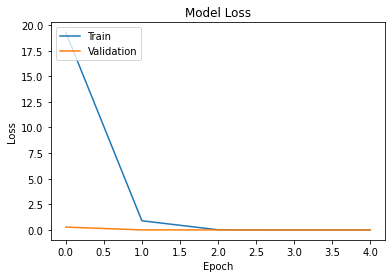

In [13]:
# Get the training history for model 2
# The 'history2' variable contains information about the training of the model, such as the loss and accuracy over time
history2 = history2.history

# Plot the accuracy of the model
# The 'acc' key in the 'history2' dictionary contains the training accuracy
# The 'val_acc' key in the 'history2' dictionary contains the validation accuracy
plt.plot(history2['acc'])
plt.plot(history2['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss of the model
# The 'loss' key in the 'history2' dictionary contains the training loss
# The 'val_loss' key in the 'history2' dictionary contains the validation loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Comparative Plots

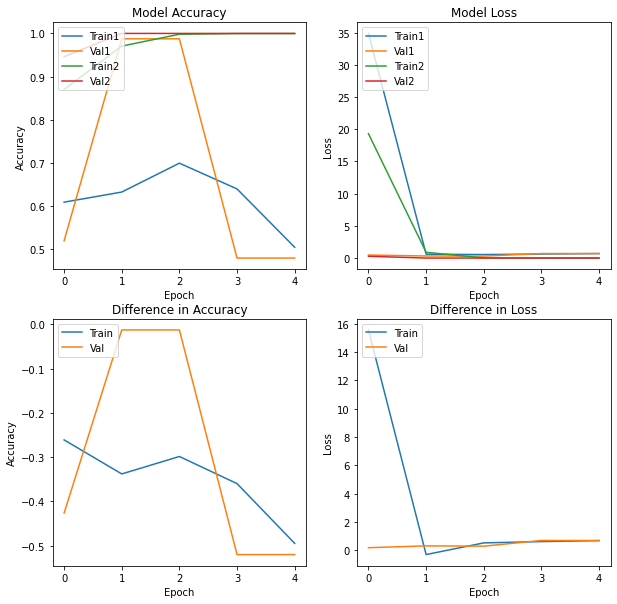

In [14]:
# Create subplots for the accuracy and loss plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the accuracy of model1 and model2
# The 'acc' key in the 'history' dictionary contains the training accuracy for model 1
# The 'val_acc' key in the 'history' dictionary contains the validation accuracy for model 1
# The 'acc' key in the 'history2' dictionary contains the training accuracy for model 2
# The 'val_acc' key in the 'history2' dictionary contains the validation accuracy for model 2
axs[0, 0].plot(history['acc'])
axs[0, 0].plot(history['val_acc'])
axs[0, 0].plot(history2['acc'])
axs[0, 0].plot(history2['val_acc'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(['Train1', 'Val1', 'Train2', 'Val2'], loc='upper left')

# Plot the loss of model1 and model2
# The 'loss' key in the 'history' dictionary contains the training loss for model 1
# The 'val_loss' key in the 'history' dictionary contains the validation loss for model 1
# The 'loss' key in the 'history2' dictionary contains the training loss for model 2
# The 'val_loss' key in the 'history2' dictionary contains the validation loss for model 2
axs[0, 1].plot(history['loss'])
axs[0, 1].plot(history['val_loss'])
axs[0, 1].plot(history2['loss'])
axs[0, 1].plot(history2['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(['Train1', 'Val1', 'Train2', 'Val2'], loc='upper left')

# Plot the difference in accuracy between model1 and model2
# The 'diff_acc' variable contains the difference in accuracy between model 1 and model 2
# The 'diff_val_acc' variable contains the difference in validation accuracy between model 1 and model 2
diff_acc = np.array(history['acc']) - np.array(history2['acc'])
diff_val_acc = np.array(history['val_acc']) - np.array(history2['val_acc'])
axs[1, 0].plot(diff_acc)
axs[1, 0].plot(diff_val_acc)
axs[1, 0].set_title('Difference in Accuracy')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(['Train', 'Val'], loc='upper left')

# Plot the difference in loss between model1 and model2
# The 'diff_loss' variable contains the difference in loss between model 1 and model 2
# The 'diff_val_loss' variable contains the difference in validation loss between model 1 and model 2
diff_loss = np.array(history['loss']) - np.array(history2['loss'])
diff_val_loss = np.array(history['val_loss']) - np.array(history2['val_loss'])
axs[1, 1].plot(diff_loss)
axs[1, 1].plot(diff_val_loss)
axs[1, 1].set_title('Difference in Loss')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(['Train', 'Val'], loc='upper left')

# Show the plot
plt.show()


# 2. ROC curves


## Preparing data to test

In [9]:
# Check if the  dataset pickle file exists and load it if it does
if (os.path.exists('training_data.pkl')):
    dataset = load(open('training_data.pkl', 'rb'))

In [12]:
# Set the image size to 200
ImgSize = 200

# Randomly shuffle the dataset
# The 'dataset' variable contains the original dataset
random.shuffle(dataset)  # Shuffle the dataset in place

# Balance the data
# The 'balance_data' function balances the classes in the dataset to have a specified number of instances for each class
target_c0 = 15  # Target number of instances for class 0
target_c1 = 500  # Target number of instances for class 1
balanced_dataset = balance_data(training_data, target_c0, target_c1)

# Set the dataset to the balanced dataset
dataset = balanced_dataset


In [14]:
X_data = np.array([i[0] for i in dataset]).reshape(-1, ImgSize, ImgSize, 3)
y_data = [i[1] for i in dataset]


In [18]:
y_data=np.array(y_data)

y_data = y_data.astype(float)

In [16]:
# Load a saved Keras model from the 'best_main_model_ZZ.h5' file
model = tf.keras.models.load_model('best_main_model_ZZ.h5')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


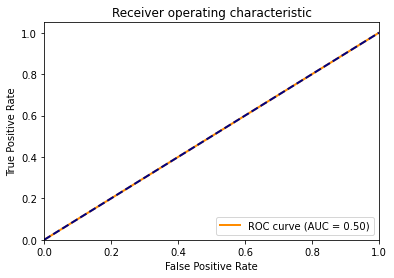

In [19]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set using the loaded Keras model
# X_testz and y_testz are the test data and labels, respectively
y_pred = model.predict(X_testz).ravel()

# Compute ROC curve and ROC area for each class
# The 'roc_curve' function computes the ROC curve given the true labels and predicted probabilities
# The 'auc' function computes the area under the ROC curve (AUC)
fpr, tpr, _ = roc_curve(y_testz, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
# The following code creates a plot of the ROC curve using matplotlib
plt.figure()
lw = 2  # Line width for plot
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)  # Plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Plot random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')  # Y-axis label
plt.title('Receiver operating characteristic')  # Plot title
plt.legend(loc="lower right")  # Add legend to plot
plt.show()  # Display the plot


# 3 . Predictive scores by different data augmentation methods and different folds of minority data augmentation

In [9]:
def create_minority_folds(X_train0, y_train0, num_fold, augmentation_method):
    # Define data augmentation based on the augmentation_method parameter
    if augmentation_method == 'rotate':
        datagen = ImageDataGenerator(rotation_range=30)
    elif augmentation_method == 'flip':
        datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    elif augmentation_method == 'zoom':
        datagen = ImageDataGenerator(zoom_range=0.2)
    else:
        raise ValueError(f"Invalid augmentation method: {augmentation_method}")

    # Fit the data generator on the minority class samples
    datagen.fit(X_train0)

    # Create folds using KFold
    kf = KFold(n_splits=num_fold)

    minority_folds = []

    for train_indices, _ in kf.split(X_train0):
        X_fold = np.zeros_like(X_train0)
        y_fold = np.zeros_like(y_train0)

        for i, index in enumerate(train_indices):
            # Apply data augmentation to the current sample
            X_augmented = datagen.random_transform(X_train0[index])
            X_fold[i] = X_augmented
            y_fold[i] = y_train0[index]

        minority_folds.append((X_fold, y_fold))

    return minority_folds


In [2]:
import os
import random
import numpy as np
from pickle import load
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint


def Train_augmentation_folds(ImgSize, loss_function, data_augmentation_methods, num_folds, num_epochs, batch_size):
    """
    Trains a model on augmented data for multiple folds and augmentation methods.
    
    Parameters:
    -----------
    ImgSize : int
        The size of the input images.
    loss_function : str
        The loss function used to compile the model.
    data_augmentation_methods : list of str
        The list of data augmentation methods to be applied.
    num_folds : list of int
        The list of number of folds to be created for the minority class.
    num_epochs : int
        The number of epochs for training the model.
    batch_size : int
        The batch size for training the model.
    
    Returns:
    --------
    predictive_scores : list of tuples
        The list of tuples containing the predictive scores for each fold and augmentation method.
    """
    # Load training data from file
    if os.path.exists('training_data.pkl'):
        training_data = load(open('training_data.pkl', 'rb'))
    else:
        raise ValueError("Training data file not found!")
        
    # Shuffle the training data
    random.shuffle(training_data)
    
    # Set target class counts
    target_c0 = 15
    target_c1 = 1000
    
    # Balance the training data
    balanced_training_data = balance_data(training_data, target_c0, target_c1)
    
    # Split the input and output data
    X_train = np.array([i[0] for i in balanced_training_data]).reshape(-1, ImgSize, ImgSize, 3)
    y_train = [i[1] for i in balanced_training_data]
    
    # Convert the output data to numpy array and float type
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    
    # Split the minority class data into folds and augment with the specified methods
    X_train0 = X_train[y_train == 0]
    y_train0 = y_train[y_train == 0]
    X_train1 = X_train[y_train == 1]
    y_train1 = y_train[y_train == 1]
    X_testz, y_testz = [], []
    predictive_scores = []

    for augmentation_method in data_augmentation_methods:
        for num_fold in num_folds:
            # Create minority class folds
            minority_folds = create_minority_folds(X_train0, y_train0, num_fold, augmentation_method)
            
            # Train the model on each fold
            for fold in minority_folds:
                # Combine the augmented minority class data and majority class data
                X_train_augmented = np.concatenate((X_train1, fold[0]), axis=0)
                y_train_augmented = np.concatenate((y_train1, np.zeros(fold[0].shape[0])))
                
                # Shuffle the combined data
                indices = np.arange(X_train_augmented.shape[0])
                np.random.shuffle(indices)
                X_train_augmented = X_train_augmented[indices]
                y_train_augmented = y_train_augmented[indices]
                
                # Define the model architecture
                model = Sequential()
                model.add(Conv2D(32, (3,3), activation='relu', input_shape=(ImgSize, ImgSize, 3)))
                model.add(MaxPooling2D((2,2)))
                # Add Flatten layer to convert the 2D feature maps to 1D vector
                model.add(Flatten()) 
                # Add Dense layer with 32 units and ReLU activation
                model.add(Dense(32, activation='relu'))
                # Add Dropout layer with 0.6 dropout rate
                model.add(Dropout(0.6))
                # Add output layer with 1 unit and sigmoid activation
                model.add(Dense(1, activation='sigmoid'))
            
                # Compile the model with specified optimizer, loss function and evaluation metric
                model.compile(optimizer='Adam', loss=loss_function, metrics=['accuracy'])
                
                # Define the learning rate schedule
                def step_decay(epoch):
                    initial_lr = 0.001
                    drop = 0.5
                    epochs_drop = 5
                    lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
                    return lr
                lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
                
                # Define early stopping callback
                early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
                
                # Define model checkpoint callback to save the best model
                checkpoint = ModelCheckpoint('best_other_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                
                # Split the data into train and validation sets
                X_trainz, X_testz_fold, y_trainz, y_testz_fold = train_test_split(X_train_augmented, y_train_augmented, test_size=0.20, random_state=42)
                
                # Convert the output data to numpy array and float type
                y_trainz = np.array(y_trainz)
                y_testz_fold = np.array(y_testz_fold)
                y_trainz = y_trainz.astype(float)
                y_testz_fold = y_testz_fold.astype(float)
                
                # Train the model with specified number of epochs and batch size
                # using callbacks for learning rate schedule, early stopping and model checkpoint
                history = model.fit(X_trainz, y_trainz, epochs=num_epochs, batch_size=batch_size, validation_data=(X_testz_fold, y_testz_fold), callbacks=[lr_scheduler, early_stop, checkpoint], verbose=1)
                
                # Evaluate the model on the validation set
                scores = model.evaluate(X_testz_fold, y_testz_fold, verbose=0)
                accuracy = scores[1]
                y_pred = np.round(model.predict(X_testz_fold))
                
                # Calculate precision, recall and f1-score
                precision = precision_score(y_testz_fold, y_pred)
                recall = recall_score(y_testz_fold, y_pred)
                f1score = f1_score(y_testz_fold, y_pred)
                
                # Add the predictive scores to the list
                predictive_scores.append((augmentation_method, num_fold, accuracy, precision, recall, f1score))
                
                # Print the predictive scores
                print(f"Augmentation method: {augmentation_method}, Fold: {num_fold}")
                print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1score}")
                print("="*30)
        
            # Combine all the minority class folds and evaluate the model
            X_testz_fold, y_testz_fold = zip(*minority_folds)
            X_testz_fold, X_testz_fold, y_testz_fold, y_testz_fold = train_test_split(X_testz_fold[0], y_testz_fold, test_size=0.20, random_state=42)
                    # Evaluate the model on the test set
            scores = model.evaluate(X_testz_fold, y_testz_fold, verbose=0)
            accuracy = scores[1]
            y_pred = np.round(model.predict(X_testz_fold))
            
            # Calculate precision, recall and f1-score
            precision = precision_score(y_testz_fold, y_pred)
            recall = recall_score(y_testz_fold, y_pred)
            f1score = f1_score(y_testz_fold, y_pred)
            
            # Add the predictive scores to the list
            predictive_scores.append((augmentation_method, "All Folds", accuracy, precision, recall, f1score))
            
            # Print the predictive scores
            print(f"Augmentation method: {augmentation_method}, All Folds")
            print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1score}")
            print("="*30)

# Return the predictive scores
    return predictive_scores




In [ ]:
predictive_scores = Train_augmentation_folds(ImgSize=200, loss_function='binary_crossentropy', data_augmentation_methods=['rotate', 'flip', 'zoom'], num_folds=[3,4,5], num_epochs=5, batch_size=16)

In [14]:
# Convert predictive_scores to a pandas DataFrame
df = pd.DataFrame(predictive_scores, columns=['Augmentation Method', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Filter out rows with Fold=="All Folds"
df = df[df['Fold'] != 'All Folds']

# Group the rows by Augmentation Method and Fold, and calculate the mean and standard deviation of the evaluation metrics
df_grouped = df.groupby(['Augmentation Method', 'Fold']).agg({'Accuracy': [np.mean, np.std],
                                                              'Precision': [np.mean, np.std],
                                                              'Recall': [np.mean, np.std],
                                                              'F1-Score': [np.mean, np.std]})

# Flatten the multi-level column index into a single level
df_grouped.columns = df_grouped.columns.map('_'.join)

# Reset the index to create columns for Augmentation Method and Fold
df_grouped = df_grouped.reset_index()

# Display the table
print(df_grouped)


  Augmentation Method  Fold  Accuracy_mean  Accuracy_std  Precision_mean  \
0                flip     3       0.988506      0.007525        0.990107   
1                flip     4       0.993842      0.006199        0.993836   
2                flip     5       0.985222      0.011553        0.985187   
3              rotate     3       0.990148      0.008532        0.990083   
4              rotate     4       0.990148      0.010642        0.990111   
5              rotate     5       0.989163      0.005396        0.989148   
6                zoom     3       0.988506      0.007525        0.988498   
7                zoom     4       0.991379      0.007389        0.991367   
8                zoom     5       0.988177      0.002698        0.988124   

   Precision_std  Recall_mean  Recall_std  F1-Score_mean  F1-Score_std  
0       0.008582      0.99835    0.002858       0.994193      0.003838  
1       0.006197      1.00000    0.000000       0.996901      0.003123  
2       0.011542    

# 4. Sensitivity analysis on three predictive scores with twofold mixup data augmentation on minority training data

In [6]:
import numpy as np

def create_minority_folds_mixup(X, y, num_folds, alpha):
    # Separate the minority class samples and their corresponding labels
    minority_samples = X[y == 0]
    minority_labels = y[y == 0]

    minority_folds = []

    # Calculate the size of each fold
    fold_size = int(len(minority_samples) / num_folds)

    # Create a fold for each iteration
    for i in range(num_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size

        # Make sure the last fold includes all remaining samples
        if i == num_folds - 1:
            end_index = len(minority_samples)

        # Select the samples and labels for the current fold
        fold_samples = minority_samples[start_index:end_index]
        fold_labels = minority_labels[start_index:end_index]

        mixup_samples = []
        mixup_labels = []

        # Perform Mixup augmentation for each sample in the fold
        for j in range(len(fold_samples)):
            # Select a random sample to mix with
            k = np.random.randint(len(fold_samples))

            # Generate a mixing coefficient between 0 and 1
            lam = np.random.beta(alpha, alpha)

            # Mix the current sample with the randomly selected sample
            mixup_samples.append(lam * fold_samples[j] + (1 - lam) * fold_samples[k])
            mixup_labels.append(lam * fold_labels[j] + (1 - lam) * fold_labels[k])

        # Convert the mixed-up samples and labels to numpy arrays
        mixup_samples = np.array(mixup_samples)
        mixup_labels = np.array(mixup_labels)

        # Add the mixed-up samples and labels to the list of minority class folds
        minority_folds.append((mixup_samples, mixup_labels))

    # Return the list of minority class folds
    return minority_folds


In [7]:
def sensitivity_analysis_twofold_mixup(ImgSize, loss_function, num_epochs, batch_size, num_folds_list, alpha_list):
    # Load the training data if it exists
    if (os.path.exists('training_data.pkl')):
        training_data = load(open('training_data.pkl', 'rb'))

    # Shuffle the training data and balance the classes
    random.shuffle(training_data)
    target_c0 = 15
    target_c1 = 1000
    balanced_training_data = balance_data(training_data, target_c0, target_c1)

    # Separate the input and label data for training
    X_train = np.array([i[0] for i in balanced_training_data]).reshape(-1, ImgSize, ImgSize, 3)
    y_train = [i[1] for i in balanced_training_data]
    y_train = np.array(y_train)
    y_train = y_train.astype(float)

    # Separate the minority class data
    X_train0 = X_train[y_train == 0]
    y_train0 = y_train[y_train == 0]

    # Separate the majority class data
    X_train1 = X_train[y_train == 1]
    y_train1 = y_train[y_train == 1]

    predictive_scores = []

    # Perform sensitivity analysis for each combination of number of folds and alpha value
    for num_folds in num_folds_list:
        for alpha in alpha_list:
            # Create the minority class folds using Mixup augmentation
            minority_folds = create_minority_folds_mixup(X_train0, y_train0, num_folds, alpha)

            for fold in minority_folds:
                # Combine the majority and minority class data for training
                X_train_augmented = np.concatenate((X_train1, fold[0]), axis=0)
                y_train_augmented = np.concatenate((y_train1, fold[1]))

                # Shuffle the training data
                indices = np.arange(X_train_augmented.shape[0])
                np.random.shuffle(indices)
                X_train_augmented = X_train_augmented[indices]
                y_train_augmented = y_train_augmented[indices]

                # Create the CNN model
                model = Sequential()
                model.add(Conv2D(32, (3,3), activation='relu', input_shape=(ImgSize, ImgSize, 3)))
                model.add(MaxPooling2D((2,2)))
                model.add(Flatten())
                model.add(Dense(32, activation='relu'))
                model.add(Dropout(0.6))
                model.add(Dense(1, activation='sigmoid'))

                # Compile the model with the given loss function
                model.compile(optimizer='Adam', loss=loss_function, metrics=['accuracy'])

                # Define the learning rate schedule
                def step_decay(epoch):
                    initial_lr = 0.001
                    drop = 0.5
                    epochs_drop = 5
                    lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
                    return lr

                lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

                # Define early stopping
                                early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

                # Define the model checkpoint
                checkpoint = ModelCheckpoint('best_twofold_mixup_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                # Split the data into training and validation sets
                X_trainz, X_testz_fold, y_trainz, y_testz_fold = train_test_split(X_train_augmented, y_train_augmented, test_size=0.20, random_state=42)

                y_trainz = np.array(y_trainz)
                y_testz_fold = np.array(y_testz_fold)

                y_trainz = y_trainz.astype(float)
                y_testz_fold = y_testz_fold.astype(float)

                # Train the CNN model with the augmented data
                history = model.fit(X_trainz, y_trainz, epochs=num_epochs, batch_size=batch_size, validation_data=(X_testz_fold, y_testz_fold), callbacks=[lr_scheduler, early_stop, checkpoint], verbose=1)

                # Evaluate the model on the validation set
                scores =model.evaluate(X_testz_fold, y_testz_fold, verbose=0)
                accuracy = scores[1]
                y_pred = np.round(model.predict(X_testz_fold))

                # Calculate the precision, recall, and F1 score
                precision = precision_score(y_testz_fold, y_pred)
                recall = recall_score(y_testz_fold, y_pred)
                f1score = f1_score(y_testz_fold, y_pred)

                # Append the results to the list of predictive scores
                predictive_scores.append((num_folds, alpha, accuracy, precision, recall, f1score))

    # Return the list of predictive scores
    return predictive_scores



In [ ]:
# Set the parameters for the sensitivity analysis
ImgSize = 200
loss_function = 'binary_crossentropy'
num_epochs = 10
batch_size = 2
num_folds_list = [3]
alpha_list = [0.2]

# Call the sensitivity_analysis_twofold_mixup function with the given parameters
predictive_scores = sensitivity_analysis_twofold_mixup(ImgSize, loss_function, num_epochs, batch_size, num_folds_list, alpha_list)


In [15]:
# Convert predictive_scores to a pandas DataFrame
import pandas as pd 
df = pd.DataFrame(predictive_scores, columns=['Num Folds', 'Alpha', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Group the rows by Num Folds and Alpha, and calculate the mean and standard deviation of the evaluation metrics
df_grouped = df.groupby(['Num Folds', 'Alpha']).agg({'Accuracy': [np.mean, np.std],
                                                        'Precision': [np.mean, np.std],
                                                        'Recall': [np.mean, np.std],
                                                        'F1-Score': [np.mean, np.std]})

# Flatten the multi-level column index into a single level
df_grouped.columns = df_grouped.columns.map('_'.join)

# Reset the index to create columns for Num Folds and Alpha
df_grouped = df_grouped.reset_index()

# Display the table
print(df_grouped)

   Num Folds  Alpha  Accuracy_mean  Accuracy_std  Precision_mean  \
0          3    0.2       0.996683      0.005745        0.996683   

   Precision_std  Recall_mean  Recall_std  F1-Score_mean  F1-Score_std  
0       0.005745          1.0         0.0       0.998333      0.002887  
